In [3]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder

df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
# we are dropping the following features:
# - "fnlwgt": this feature was created while studying the "adult" dataset.
#   Thus, we will not use this feature which is not acquired during the survey.
# - "education-num": it is encoding the same information than "education".
#   Thus, we are removing one of these 2 features.
df = df.drop(columns=['fnlwgt', 'education-num'])

y = pd.Series(
    LabelEncoder().fit_transform(y),
    name=y.name
)

###############################################################################
# The "adult" dataset as a class ratio of about 3:1

classes_count = y.value_counts()
print(classes_count)

###############################################################################
# This dataset is only slightly imbalanced. To better highlight the effect of
# learning from an imbalanced dataset, we will increase its ratio to 10:1

import numpy as np

rng = np.random.RandomState(0)

# we define a ratio 10:1
n_samples_minority_class = classes_count.max() // 10

mask_minority_class = y == classes_count.idxmin()
indices_minority_class = np.flatnonzero(mask_minority_class)
indices_minority_class_subsampled = rng.choice(
    indices_minority_class, size=n_samples_minority_class, replace=False
)

# sample the dataframe
df_res = pd.concat([df.loc[~mask_minority_class, :],
                    df.loc[indices_minority_class_subsampled, :]])
# sample the target
y_res = pd.concat([y.loc[~mask_minority_class],
                   y.loc[indices_minority_class_subsampled]])
print(y_res.value_counts())

###############################################################################
# For the rest of the notebook, we will make a single split to get training
# and testing data. Note that in practise, you should always use
# cross-validation to have an estimate of the performance variation. You can
# refer to the following example showing how to use a scikit-learn pipeline
# within a grid-search:
# :ref:`sphx_glr_auto_examples_compose_plot_compare_reduction.py`

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_res, y_res, stratify=y_res, random_state=42
)

/home/glemaitre/miniconda3/envs/dev/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/glemaitre/miniconda3/envs/dev/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0    37155
1    11687
Name: class, dtype: int64
0    37155
1     3715
Name: class, dtype: int64


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

preprocessor_linear = ColumnTransformer(
    [("num-pipe", num_pipe, selector(dtype_include=np.number)),
     ("cat-pipe", cat_pipe, selector(dtype_include="category"))],
    n_jobs=2
)

In [6]:
from sklearn.linear_model import LogisticRegression

lr_clf = make_pipeline(
    preprocessor_linear, LogisticRegression(max_iter=1000)
)

In [7]:
from sklearn.metrics import balanced_accuracy_score

y_pred = lr_clf.fit(X_train, y_train).predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6347141270720684

## CV strategy by averaging validation score and pick-up the cut-off threshold

In [19]:
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import _safe_indexing


def _compute_cutoffs_scores(estimator, X, y, train_idx, val_idx, method, score_method):
    X_train = _safe_indexing(X, train_idx)
    X_val = _safe_indexing(X, val_idx)
    y_train = _safe_indexing(y, train_idx)
    y_val = _safe_indexing(y, val_idx)
    
    estimator.fit(X_train, y_train)
    y_score = getattr(estimator, method)(X_val)
    
    if y_score.ndim == 2:
        # FIXME: we should use pos_label to select the relevent column
        y_score = y_score[:, 1]
        
    # unique will sort the array in the same time
    potential_thresholds = np.unique(y_score)
    score_thresholds = np.array([
        score_method(y_val, (y_score >= th).astype(int))
        for th in potential_thresholds
    ])
    return potential_thresholds, score_thresholds
        


def find_threshold_by_best_average_score_cv(estimator, X, y, cv, method, score_method, n_threholds, n_jobs=-1):
    cv_results = {}
    
    model = clone(estimator)
    results = Parallel(n_jobs=n_jobs)(
        delayed(_compute_cutoffs_scores)(
            model, X, y, train_idx, val_idx, method, score_method
        )
        for train_idx, val_idx in cv.split(X, y)
    )
    
    scores, thresholds = zip(*results)
    min_threshod = np.min([th.min() for th in thresholds])
    max_threshod = np.max([th.max() for th in thresholds])
    thresholds_interpolated = np.linspace(min_threshod, max_threshod, num=n_threholds)

In [20]:
cv = StratifiedKFold(shuffle=True, random_state=0, n_splits=2)
xx = find_threshold_by_best_average_score_cv(
    lr_clf, X_train, y_train, cv, "decision_function", balanced_accuracy_score, 100
)

In [23]:
a, b = zip(*xx)

In [30]:
np.min([aa.min() for aa in a])

-10.433049445379181

In [6]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import _safe_indexing

cv = StratifiedKFold(shuffle=True, random_state=0)

score_val = []
thresholds_val = []
X_val = []
y_true = []
y_score = []
model = []
for train_idx, val_idx in cv.split(X_train, y_train):
    # split the data into the train and validation tests
    X_fold_train = _safe_indexing(X_train, train_idx)
    X_fold_val = _safe_indexing(X_train, val_idx)
    X_val.append(X_fold_val)
    y_fold_train = _safe_indexing(y_train, train_idx)
    y_fold_val = _safe_indexing(y_train, val_idx)
    # train a model for this cv
    model_fold = clone(lr_clf).fit(X_fold_train, y_fold_train)
    model.append(model_fold)
    y_score_model = model_fold.predict_proba(X_fold_val)[:, 1]
    thresholds_fold_val = np.unique(y_score_model)
    score_fold_val = []
    for th in thresholds_fold_val:
        score_fold_val.append(
            balanced_accuracy_score(y_fold_val, (y_score_model >= th).astype(int))
        )
    score_val.append(score_fold_val)
    thresholds_val.append(thresholds_fold_val)
    y_true.append(y_fold_val)
    y_score.append(y_score_model)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

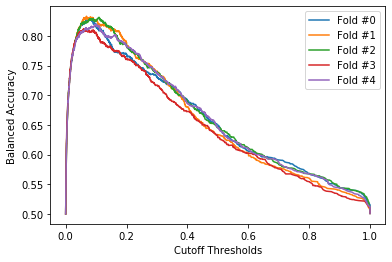

In [8]:
fig, ax = plt.subplots()
for fold_idx in range(len(score_val)):
    ax.plot(thresholds_val[fold_idx], score_val[fold_idx], label=f"Fold #{fold_idx}")
plt.xlabel("Cutoff Thresholds")
plt.ylabel("Balanced Accuracy")
plt.legend()

In [9]:
threshold_interpolated = np.linspace(0, 1, num=1000)
score_val_interpolated = []
for fold_idx in range(len(score_val)):
    score_val_interpolated.append(
        np.interp(
            threshold_interpolated,
            thresholds_val[fold_idx],
            score_val[fold_idx],
        )
    )

Cutoff point on fold #0: 0.08208208208208208
Cutoff point on fold #1: 0.06806806806806806
Cutoff point on fold #2: 0.1091091091091091
Cutoff point on fold #3: 0.05905905905905906
Cutoff point on fold #4: 0.0970970970970971
Cutoff point from best mean score 0.08508508508508508
Averaged cutoff point 0.08308308308308307


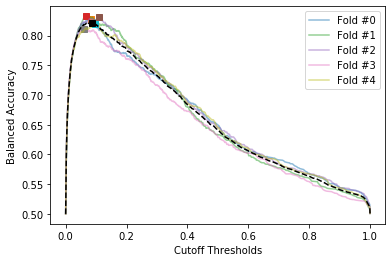

In [10]:
fig, ax = plt.subplots()
cutoff_folds = []
for fold_idx in range(len(score_val)):
    ax.plot(threshold_interpolated, score_val_interpolated[fold_idx], label=f"Fold #{fold_idx}", alpha=0.5)
    idx = np.argmax(score_val_interpolated[fold_idx])
    ax.plot(threshold_interpolated[idx], score_val_interpolated[fold_idx][idx], marker="s")
    cutoff_folds.append(threshold_interpolated[idx])
    print(f"Cutoff point on fold #{fold_idx}: {threshold_interpolated[idx]}")
ax.plot(threshold_interpolated, np.mean(score_val_interpolated, axis=0), "--k")
cutoff_points = threshold_interpolated[np.argmax(np.mean(score_val_interpolated, axis=0))]
ax.plot(cutoff_points, np.mean(score_val_interpolated, axis=0).max(), marker="s", color="k")
plt.xlabel("Cutoff Thresholds")
plt.ylabel("Balanced Accuracy")
plt.legend()
print(f"Cutoff point from best mean score {cutoff_points}")
print(f"Averaged cutoff point {np.mean(cutoff_folds)}")

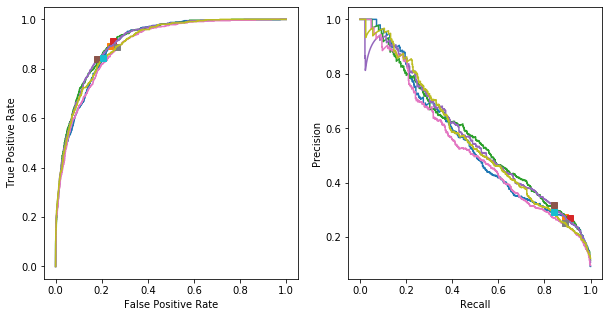

In [11]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for fold_idx in range(len(y_true)):
    fpr, tpr, thresholds = roc_curve(y_true[fold_idx], y_score[fold_idx])
    ax[0].plot(fpr, tpr)
    idx = thresholds.size - np.searchsorted(thresholds[::-1], cutoff_folds[fold_idx])
    ax[0].plot(fpr[idx], tpr[idx], "s")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    precision, recall, thresholds = precision_recall_curve(y_true[fold_idx], y_score[fold_idx])
    ax[1].plot(recall, precision)
    idx = np.searchsorted(thresholds, cutoff_folds[fold_idx])
    ax[1].plot(recall[idx], precision[idx], "s")
    ax[1].set(xlabel="Recall", ylabel="Precision")

Refit the model on the full training set and check the performance on the testing set with the threshold which correspond to the best mean score on the validation sets across the differnt folds.

In [13]:
model = clone(lr_clf)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
print(balanced_accuracy_score(y_test, (y_pred >= cutoff_points).astype(int)))

0.8148965737336926


## Cross-val predict

In [14]:
from sklearn.model_selection import cross_val_predict

model = clone(lr_clf)
y_score = cross_val_predict(model, X_train, y_train, method="predict_proba")
y_score = y_score[:, 1]

In [15]:
scores = []
for th in threshold_interpolated:
    scores.append(
        balanced_accuracy_score(y_train, (y_score >= th).astype(int))
    )

Cutoff threshold: 0.0940940940940941


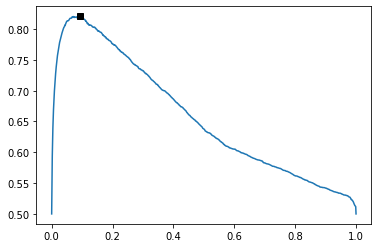

In [16]:
plt.plot(threshold_interpolated, scores)
idx = np.argmax(scores)
plt.plot(threshold_interpolated[idx], scores[idx], marker="s", color="k")
print(f"Cutoff threshold: {threshold_interpolated[idx]}")

Refit a model on the entire training set and check the performance on the training set with the threshold found by cross-val predict routine

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
print(balanced_accuracy_score(y_test, (y_pred >= threshold_interpolated[idx]).astype(int)))

0.8146285390743662


## single train-test split

In [18]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train, y_train, stratify=y_train, random_state=0
) 

In [19]:
model = clone(lr_clf).fit(X_train_sub, y_train_sub)

In [20]:
y_score = model.predict_proba(X_val_sub)
y_score = y_score[:, 1]

In [21]:
scores = []
for th in threshold_interpolated:
    scores.append(
        balanced_accuracy_score(y_val_sub, (y_score >= th).astype(int))
    )

Cutoff threshold: 0.07207207207207207


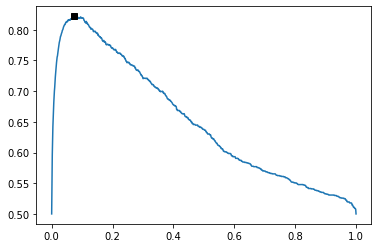

In [22]:
plt.plot(threshold_interpolated, scores)
idx = np.argmax(scores)
plt.plot(threshold_interpolated[idx], scores[idx], marker="s", color="k")
print(f"Cutoff threshold: {threshold_interpolated[idx]}")

Use the fitted model on the training set to check the performance using the split found on the validation set.

In [23]:
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
print(balanced_accuracy_score(y_test, (y_pred >= threshold_interpolated[idx]).astype(int)))

0.8128499268959513
